In [383]:
import pandas as pd
import numpy as np
import random
import string

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from numpy import arange, argmax


import matplotlib.pyplot as plt
%matplotlib inline


pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 1500)
pd.set_option("display.max_colwidth", None)

## Load the data

In [264]:
balances_df = pd.read_csv("balances.csv", sep=";")
collateral_df = pd.read_csv("collateral.csv", sep=";")
customers_df = pd.read_csv("customers.csv", sep=";")


balances_prep = pd.read_csv("balances_prep_simple_v2.csv")
balances_prep.drop("Unnamed: 0", axis=1, inplace=True)

In [265]:
balances_prep["prepayment_status_unique"].head(100).value_counts()

['no']                        79
['own']                       16
['refinanced other banks']     3
['refinanced-UC']              2
Name: prepayment_status_unique, dtype: int64

## Transform targets

In [266]:
def new_labels(row):
    return 0 if row["prepayment_status_unique"] == "['no']" else 1

In [267]:
def new_rating(row, col_name):
    
    val = row
    if "+" in val:
        res_val = float(val[0]+".5")
    elif "-" in val:
        res = float(val[0]+".9")
        res_val = res - 1
    else:
        res_val = float(val)
    
    return res_val

In [268]:
rating_cols = ["customer_rating_min", "customer_rating_max", "customer_rating_modeX"]
for col in rating_cols:
#     print(col)
    balances_prep[col] = balances_prep[col].apply(lambda x: new_rating(x, col_name=col))

In [269]:
balances_prep["prepayment_status_unique"] = balances_prep.apply(new_labels, axis=1)

In [270]:
balances_prep["prepayment_status_unique"].head(100).value_counts()

0    79
1    21
Name: prepayment_status_unique, dtype: int64

In [271]:
balances_prep.shape

(39339, 65)

In [272]:
balances_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39339 entries, 0 to 39338
Data columns (total 65 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   customer_id_                                 39339 non-null  object 
 1   account_id_                                  39339 non-null  object 
 2   open_date_                                   39339 non-null  object 
 3   original_principal_min                       39339 non-null  int64  
 4   original_principal_max                       39339 non-null  int64  
 5   original_principal_std                       39339 non-null  float64
 6   original_principal_max_minus_min             39339 non-null  int64  
 7   reporting_date_count                         39339 non-null  int64  
 8   total_cust_exposure_min                      39339 non-null  int64  
 9   total_cust_exposure_max                      39339 non-null  int64  
 10

## Sample

In [273]:
sample = balances_prep.sample(frac=0.33, replace=True, random_state=1)
sample.to_csv("balances_prep_simple_v2_sample.csv")

## Data Splitting

In [274]:
X = balances_prep.loc[:, ~balances_prep.columns.isin(['prepayment_status_unique'])]
Y = balances_prep["prepayment_status_unique"]

In [275]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=24)

In [276]:
test_data = pd.concat([X_test, y_test], axis=1)
test_data.sort_index(inplace=True)

In [277]:
X_train.sort_index(inplace=True)
y_train.sort_index(inplace=True)
train_data = pd.concat([X_train, y_train], axis=1)

In [278]:
train_data.head()

,customer_id_,account_id_,open_date_,original_principal_min,original_principal_max,original_principal_std,original_principal_max_minus_min,reporting_date_count,total_cust_exposure_min,total_cust_exposure_max,overdraft_min,overdraft_max,overdraft_size,overdraft_count0,overdraft_count1,overdraft_count2plus,consumer_loan_min,consumer_loan_max,consumer_loan_size,consumer_loan_count0,consumer_loan_count1,consumer_loan_count2plus,credit_card_min,credit_card_max,credit_card_size,credit_card_count0,credit_card_count1,credit_card_count2plus,customer_rating_min,customer_rating_max,customer_rating_modeX,maturity_date_min,maturity_date_max,maturity_date_max_minus_min,l_period_min,l_period_max,l_period_max_minus_min,interest_rate_min,interest_rate_max,interest_rate_max_minus_min,interest_rate_modeX,exp_monthly_payments_min,exp_monthly_payments_max,exp_monthly_payments_std,exp_monthly_payments_max_minus_min,current_principal_min,current_principal_max,current_principal_max_minus_min,interest_payment_min,interest_payment_max,interest_payment_max_minus_min,principal_payment_min,principal_payment_max,principal_payment_max_minus_min,deducted_principal_min,deducted_principal_max,deducted_principal_max_minus_min,deducted_vs_principal_payment_min,deducted_vs_principal_payment_max,deducted_vs_principal_payment_mean,deducted_vs_principal_payment_max_minus_min,principal_left_pctg_min,principal_left_pctg_max,principal_left_pctg_max_minus_min,prepayment_status_unique
0,0x000100F424893C746F,0xF7CDAD654B6CE06334F9FE655212AAD1,2017-06-29,64800,64800,0.0,0,44,56155,63355,0,0,44,44,0,0,0,0,44,44,0,0,0,0,44,44,0,0,3.0,5.5,3.5,2042-06-29,2042-06-29,0,24,24,0,3.70,3.70,0.0,3.70,339.819283,339.819283,0.0,0.0,56155,62342,6187,173.144583,192.221167,19.076583,147.598116,166.674700,19.076583,0.0,2458.0,2458.0,-164.251200,2310.401884,39.390899,2474.653083,87.0,96.0,9.0,0
1,0x000224F02B4B39DDFE,0x5568E6E4AEB2DF832D6444950125EECB,2016-08-16,74880,74880,0.0,0,11,70449,72710,0,0,11,11,0,0,0,0,11,11,0,0,0,0,11,11,0,0,4.0,5.5,4.0,2042-08-16,2042-08-16,0,25,25,0,3.90,3.90,0.0,3.90,391.121433,391.121433,0.0,0.0,69729,71273,1544,226.619250,231.637250,5.018000,159.484183,164.502183,5.018000,147.0,3607.0,3460.0,-12.961933,3447.515817,306.287522,3460.477750,93.0,95.0,2.0,1
2,0x00025DA4C145ED8EBF,0x8C794E5D7336C4FE59B85E4400973723,2022-04-13,54000,54000,0.0,0,3,53248,54000,0,0,3,3,0,0,0,0,3,3,0,0,0,0,3,3,0,0,5.5,5.5,5.5,2033-04-13,2033-04-13,0,11,11,0,2.48,2.48,0.0,2.48,467.844781,467.844781,0.0,0.0,53248,54000,752,110.045867,111.600000,1.554133,356.244781,357.798915,1.554133,0.0,398.0,398.0,-356.244781,40.932685,-106.370337,397.177467,99.0,100.0,1.0,0
4,0x0004EAC7528D4869C1,0x1DE89AAB80B0FE12FBA0E35F21DDA118,2021-07-07,118320,118320,0.0,0,12,95275,116897,0,0,12,12,0,0,0,0,12,12,0,0,0,0,12,12,0,0,3.0,3.9,3.9,2051-07-07,2051-07-07,0,29,29,0,2.49,2.49,0.0,2.49,477.741699,477.741699,0.0,0.0,95275,116897,21622,197.695625,242.561275,44.865650,235.180424,280.046074,44.865650,-21622.0,22149.0,43771.0,-21857.180424,21870.813126,-65.958891,43727.993550,81.0,99.0,18.0,0
5,0x00056F83F4501DBED4,0xD0CF1AA5C97B822BC8AF3AB67852B9A0,2012-02-22,79907,79907,0.0,0,44,68706,74000,0,0,44,44,0,0,0,0,44,44,0,0,0,0,44,44,0,0,5.0,8.5,6.9,2047-02-22,2047-02-22,0,35,35,0,4.00,4.00,0.0,4.00,353.808012,353.808012,0.0,0.0,68706,74000,5294,229.020000,246.666667,17.646667,107.141346,124.788012,17.646667,0.0,5907.0,5907.0,-122.524679,5799.858654,138.666382,5922.383333,86.0,93.0,7.0,0


In [279]:
train_data.shape

(27537, 65)

In [280]:
test_data.head()

,customer_id_,account_id_,open_date_,original_principal_min,original_principal_max,original_principal_std,original_principal_max_minus_min,reporting_date_count,total_cust_exposure_min,total_cust_exposure_max,overdraft_min,overdraft_max,overdraft_size,overdraft_count0,overdraft_count1,overdraft_count2plus,consumer_loan_min,consumer_loan_max,consumer_loan_size,consumer_loan_count0,consumer_loan_count1,consumer_loan_count2plus,credit_card_min,credit_card_max,credit_card_size,credit_card_count0,credit_card_count1,credit_card_count2plus,customer_rating_min,customer_rating_max,customer_rating_modeX,maturity_date_min,maturity_date_max,maturity_date_max_minus_min,l_period_min,l_period_max,l_period_max_minus_min,interest_rate_min,interest_rate_max,interest_rate_max_minus_min,interest_rate_modeX,exp_monthly_payments_min,exp_monthly_payments_max,exp_monthly_payments_std,exp_monthly_payments_max_minus_min,current_principal_min,current_principal_max,current_principal_max_minus_min,interest_payment_min,interest_payment_max,interest_payment_max_minus_min,principal_payment_min,principal_payment_max,principal_payment_max_minus_min,deducted_principal_min,deducted_principal_max,deducted_principal_max_minus_min,deducted_vs_principal_payment_min,deducted_vs_principal_payment_max,deducted_vs_principal_payment_mean,deducted_vs_principal_payment_max_minus_min,principal_left_pctg_min,principal_left_pctg_max,principal_left_pctg_max_minus_min,prepayment_status_unique
3,0x0003C2466FAE7F0BEA,0xAAD9093643AACB7C73D1DAB125D551FE,2018-05-08,93600,93600,0.0,0,44,87324,92598,0,0,44,44,0,0,0,0,44,44,0,0,0,0,44,44,0,0,3.0,6.5,3.5,2053-05-08,2053-05-08,0,35,35,0,3.35,3.35,0.00,3.35,378.749527,378.749527,0.000000,0.000000,87324,92598,5274,243.779500,258.50275,14.723250,120.246777,134.970027,14.723250,0.0,1002.0,1002.0,-133.096819,881.753223,15.045854,1014.850042,93.0,99.0,6.0,0
10,0x00125FAF68C8D3F3D9,0x5C4EBF7B50A9E689B2BF6005B71C9A06,2020-05-21,248932,248932,0.0,0,26,238298,248932,0,0,26,26,0,0,0,0,26,26,0,0,0,0,26,26,0,0,4.0,6.5,5.5,2050-05-21,2050-05-21,0,29,29,0,2.70,2.70,0.00,2.70,1032.313211,1032.313211,0.000000,0.000000,237821,248932,11111,535.097250,560.09700,24.999750,472.216211,497.215961,24.999750,0.0,513.0,513.0,-491.876711,39.629539,-57.586019,531.506250,96.0,100.0,4.0,0
22,0x0024F3E9CD460D6066,0x713FC219C7B70CC55B9E569EF5EC9D20,2008-05-17,109989,109989,0.0,0,44,48108,71947,0,0,44,44,0,0,0,0,44,44,0,0,0,0,44,44,0,0,4.0,5.5,5.5,2028-05-20,2028-05-20,0,20,20,0,3.30,3.30,0.00,3.30,626.646187,626.646187,0.000000,0.000000,47037,70491,23454,129.351750,193.85025,64.498500,432.795937,497.294437,64.498500,0.0,39498.0,39498.0,-489.198437,39065.204063,965.735273,39554.402500,43.0,64.0,21.0,0
24,0x002937887088673AA9,0x82B04D6BB0BC0D6CCD4058616725AE14,2015-08-12,138360,138360,0.0,0,44,87739,119162,0,0,44,44,0,0,0,0,44,44,0,0,0,0,44,44,0,0,3.0,3.5,3.5,2032-07-01,2040-10-01,3014,16,25,9,0.62,0.75,0.13,0.69,505.931570,764.951944,64.692929,259.020375,87739,117362,29623,45.331817,73.35125,28.019433,432.580320,711.813030,279.232711,0.0,20998.0,20998.0,-709.939597,20565.419680,465.494953,21275.359277,63.0,85.0,22.0,0
26,0x002D07CF22A514F2AD,0x073F819070144722BA71D17D05B8D80B,2021-07-22,252000,252000,0.0,0,13,247786,252000,0,1,13,8,5,0,0,0,13,13,0,0,0,0,13,13,0,0,2.9,5.9,5.9,2056-07-22,2056-07-22,0,35,35,0,2.59,2.59,0.00,2.59,913.089935,913.089935,0.000000,0.000000,247786,252000,4214,534.804783,543.90000,9.095217,369.189935,378.285151,9.095217,0.0,501.0,501.0,-374.216693,130.728740,-49.707884,504.945433,98.0,100.0,2.0,0


In [281]:
test_data.shape

(11802, 65)

In [282]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27537 entries, 0 to 39338
Data columns (total 64 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   customer_id_                                 27537 non-null  object 
 1   account_id_                                  27537 non-null  object 
 2   open_date_                                   27537 non-null  object 
 3   original_principal_min                       27537 non-null  int64  
 4   original_principal_max                       27537 non-null  int64  
 5   original_principal_std                       27537 non-null  float64
 6   original_principal_max_minus_min             27537 non-null  int64  
 7   reporting_date_count                         27537 non-null  int64  
 8   total_cust_exposure_min                      27537 non-null  int64  
 9   total_cust_exposure_max                      27537 non-null  int64  
 10

## Feature Selection

In [283]:
features_selected = [col for col in X_train.columns if col not in ["customer_id_", 
                                                                   "account_id_", 
                                                                   "open_date_", 
                                                                   "maturity_date_min", 
                                                                   "maturity_date_max"]]

In [284]:
X_train_fs, X_test_fs = X_train[features_selected], X_test[features_selected]

## Standardize features

In [285]:
X_train_fs["exp_monthly_payments_std"].value_counts()

0.000000      20166
3.269785          2
0.492068          2
55.703058         2
20.079476         1
              ...  
153.097904        1
59.494099         1
52.605069         1
10.806798         1
22.397064         1
Name: exp_monthly_payments_std, Length: 7369, dtype: int64

In [286]:
X_train_fs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27537 entries, 0 to 39338
Data columns (total 59 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   original_principal_min                       27537 non-null  int64  
 1   original_principal_max                       27537 non-null  int64  
 2   original_principal_std                       27537 non-null  float64
 3   original_principal_max_minus_min             27537 non-null  int64  
 4   reporting_date_count                         27537 non-null  int64  
 5   total_cust_exposure_min                      27537 non-null  int64  
 6   total_cust_exposure_max                      27537 non-null  int64  
 7   overdraft_min                                27537 non-null  int64  
 8   overdraft_max                                27537 non-null  int64  
 9   overdraft_size                               27537 non-null  int64  
 10

In [287]:
# X_train_fs.loc[X_train_fs.isnull().any(axis=1)]

,original_principal_min,original_principal_max,original_principal_std,original_principal_max_minus_min,reporting_date_count,total_cust_exposure_min,total_cust_exposure_max,overdraft_min,overdraft_max,overdraft_size,overdraft_count0,overdraft_count1,overdraft_count2plus,consumer_loan_min,consumer_loan_max,consumer_loan_size,consumer_loan_count0,consumer_loan_count1,consumer_loan_count2plus,credit_card_min,credit_card_max,credit_card_size,credit_card_count0,credit_card_count1,credit_card_count2plus,customer_rating_min,customer_rating_max,customer_rating_modeX,maturity_date_max_minus_min,l_period_min,l_period_max,l_period_max_minus_min,interest_rate_min,interest_rate_max,interest_rate_max_minus_min,interest_rate_modeX,exp_monthly_payments_min,exp_monthly_payments_max,exp_monthly_payments_std,exp_monthly_payments_max_minus_min,current_principal_min,current_principal_max,current_principal_max_minus_min,interest_payment_min,interest_payment_max,interest_payment_max_minus_min,principal_payment_min,principal_payment_max,principal_payment_max_minus_min,deducted_principal_min,deducted_principal_max,deducted_principal_max_minus_min,deducted_vs_principal_payment_min,deducted_vs_principal_payment_max,deducted_vs_principal_payment_mean,deducted_vs_principal_payment_max_minus_min,principal_left_pctg_min,principal_left_pctg_max,principal_left_pctg_max_minus_min


In [288]:
# X_train_fs.loc[X_train_fs.isnull().any(axis=1)].shape

(0, 59)

In [292]:
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train_fs)
X_train_scaled = pd.DataFrame(data=X_train_sc, columns=features_selected)
y_train_values = y_train.values.ravel()

In [330]:
y_train.value_counts()

0    22489
1     5048
Name: prepayment_status_unique, dtype: int64

In [331]:
y_test.value_counts()

0    9638
1    2164
Name: prepayment_status_unique, dtype: int64

In [332]:
2164 / (2164 + 9638)

0.18335875275377056

In [333]:
1 - 0.18335875275377056

0.8166412472462294

## Modeling

In [318]:
# sgd_clf = SGDClassifier(loss="log", max_iter=1000, tol=-np.infty, random_state=24)
log_reg_clf = LogisticRegression(max_iter=10000000000)
forest_clf = RandomForestClassifier(n_estimators=10, random_state=24)
# gr_boost_clf = GradientBoostingClassifier()
xgb_clf = XGBClassifier()
# lgbm_clf = LGBMClassifier()

In [319]:
def select_model(model, X, y, predict_proba=False):
    
    model.fit(X, y)
    model_score = cross_val_score(model, X, y, cv=5, scoring="accuracy")
    
    y_model_predict = cross_val_predict(model, X, y, cv=5)
    
    if predict_proba:
        y_probas = cross_val_predict(model, X, y, cv=5,
                             method="predict_proba")
        y_scores = y_probas[:, 1]
    else:
        y_scores = cross_val_predict(model, X, y, cv=5,
                             method="decision_function")
    
    
    conf_matrix = confusion_matrix(y, y_model_predict)
    precision_sc = precision_score(y, y_model_predict)
    recall_sc = recall_score(y, y_model_predict)
    f1_sc = f1_score(y, y_model_predict)
    
    
    print(f" Results for the {model} are:")
    print()
    print(f" Accuracy score: {model_score.mean()}")
    print()
    print(f" Confusion matrix: \n {conf_matrix}")
    print()
    print(f" Precision: {precision_sc}")
    print(f" Recall: {recall_sc}")
    print(f" F1 score: {f1_sc}")
    
    return y_scores, y_model_predict

In [320]:
y_scores_log_reg, y_predict_log_reg = select_model(log_reg_clf, X_train_scaled, y_train_values)


 Results for the LogisticRegression(max_iter=10000000000) are:

 Accuracy score: 0.8621854155647153

 Confusion matrix: 
 [[21771   718]
 [ 3077  1971]]

 Precision: 0.7329862402380067
 Recall: 0.3904516640253566
 F1 score: 0.5094998061264057


In [321]:
y_scores_forest, y_predict_forest = select_model(forest_clf, X_train_scaled, y_train_values, predict_proba=True)

 Results for the RandomForestClassifier(n_estimators=10, random_state=24) are:

 Accuracy score: 0.9737444084830834

 Confusion matrix: 
 [[22388   101]
 [  622  4426]]

 Precision: 0.9776894190413077
 Recall: 0.876782884310618
 F1 score: 0.9244908616187989


In [322]:
y_scores_xgb, y_predict_xgb = select_model(xgb_clf, X_train_scaled, y_train_values, predict_proba=True)

 Results for the XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...) are:

 Accuracy score: 0.9769037795561969

 Confusion matrix: 
 [[22391    98]
 [  538  4510]]

 Precision: 0.9787326388888888
 Recall: 0.8934231378763867
 F1 score: 0.9341342170671085


## Predictions

In [323]:
# y_sgd_predict = sgd_clf.predict(X_test_final)
# n_correct_sgd = sum(y_sgd_predict == y_test)
# y_sgd_predict_proba = sgd_clf.predict_proba(X_test_final)
# y_sgd_predict_proba = y_sgd_predict_proba[:, 1]

y_log_reg_predict = log_reg_clf.predict(X_test_fs)
n_correct_log_reg = sum(y_log_reg_predict == y_test)
y_log_reg_predict_proba = log_reg_clf.predict_proba(X_test_fs)
y_log_reg_predict_proba = y_log_reg_predict_proba[:, 1]



y_forest_predict = forest_clf.predict(X_test_fs)
n_correct_forest = sum(y_forest_predict == y_test)
y_forest_predict_proba = forest_clf.predict_proba(X_test_fs)
y_forest_predict_proba = y_forest_predict_proba[:, 1]


# y_grb_predict = gr_boost_clf.predict(X_test_final)
# n_correct_grb = sum(y_grb_predict == y_test)
# y_grb_predict_proba = gr_boost_clf.predict_proba(X_test_final)
# y_grb_predict_proba = y_grb_predict_proba[:, 1]


y_xgb_predict = xgb_clf.predict(X_test_fs)
n_correct_xgb = sum(y_xgb_predict == y_test)
y_xgb_predict_proba = xgb_clf.predict_proba(X_test_fs)
y_xgb_predict_proba = y_xgb_predict_proba[:, 1]


# y_lgbm_predict = lgbm_clf.predict(X_test_final)
# n_correct_lgbm = sum(y_lgbm_predict == y_test)
# y_lgbm_predict_proba = lgbm_clf.predict_proba(X_test_final)
# y_lgbm_predict_proba = y_lgbm_predict_proba[:, 1]


print("Prediction Scores:")
# print(f"SGD: {(n_correct_sgd / len(y_sgd_predict))}")
print(f"LogReg: {(n_correct_log_reg / len(y_log_reg_predict))}")
print(f"RF: {(n_correct_forest / len(y_forest_predict))}")
# print(f"GRB: {(n_correct_grb / len(y_grb_predict))}")
print(f"XGB: {(n_correct_xgb / len(y_xgb_predict))}")
# print(f"LGBM: {(n_correct_lgbm / len(y_lgbm_predict))}")

Prediction Scores:
LogReg: 0.7558041009998305
RF: 0.19911879342484326
XGB: 0.20072869005253346


In [336]:
pd.Series(y_log_reg_predict).value_counts()

0    10090
1     1712
dtype: int64

In [337]:
y_test.value_counts()

0    9638
1    2164
Name: prepayment_status_unique, dtype: int64

In [338]:
pd.Series(y_forest_predict).value_counts()

1    11558
0      244
dtype: int64

In [339]:
pd.Series(y_xgb_predict).value_counts()

1    11595
0      207
dtype: int64

## Scores

In [328]:
def plot_roc_curve(fpr, tpr, color="g", label=None):
    plt.plot(fpr, tpr, linewidth=2, color=color, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title("ROC Curves", fontsize=18)
    plt.ylim(0, 1.1)

In [359]:
def plot_precision_vs_recall(precisions, recalls, color="g", label=None):
    plt.plot(recalls, precisions, color=color, linestyle='dashed', linewidth=2, label=label)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.title("PR Curves", fontsize=18)
    plt.ylim(0, 1.05)

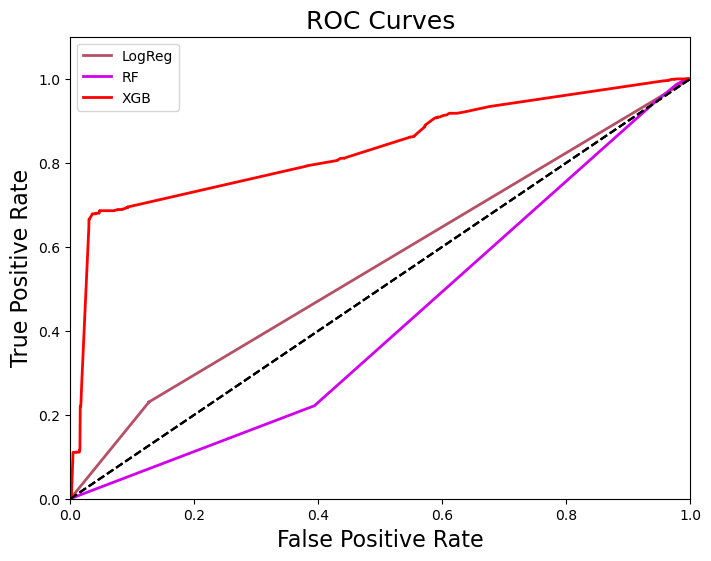

In [329]:
# fpr_sgd_test, tpr_sgd_test, thresholds_sgd_test = roc_curve(y_test, y_sgd_predict)
fpr_log_reg_test, tpr_log_reg_test, thresholds_log_reg_test = roc_curve(y_test, y_log_reg_predict_proba)
fpr_forest_test, tpr_forest_test, thresholds_forest_test = roc_curve(y_test, y_forest_predict_proba)
# fpr_grb_test, tpr_grb_test, thresholds_grb_test = roc_curve(y_test, y_grb_predict_proba)
fpr_xgb_test, tpr_xgb_test, thresholds_xgb_test = roc_curve(y_test, y_xgb_predict_proba)
# fpr_lgbm_test, tpr_lgbm_test, thresholds_lgbm_test = roc_curve(y_test, y_lgbm_predict_proba)





plt.figure(figsize=(8, 6))
# plot_roc_curve(fpr_sgd_test, tpr_sgd_test, label="SGD")
plot_roc_curve(fpr_log_reg_test, tpr_log_reg_test, color="#b55167", label="LogReg")
plot_roc_curve(fpr_forest_test, tpr_forest_test, color="#d000eb", label="RF")
# plot_roc_curve(fpr_grb_test, tpr_grb_test, color="#ebc700", label="GRB")
plot_roc_curve(fpr_xgb_test, tpr_xgb_test, color="r", label="XGB")
# plot_roc_curve(fpr_lgbm_test, tpr_lgbm_test, color="c", label="LGBM")
plt.legend()
plt.show()

ROC Curve after predictions

In [381]:
precisions_log_reg_test, recalls_log_reg_test, thresholds_log_reg_test = precision_recall_curve(y_test, y_log_reg_predict_proba)
precisions_forest_test, recalls_forest_test, thresholds_forest_test = precision_recall_curve(y_test, y_forest_predict_proba)
precisions_xgb_test, recalls_xgb_test, thresholds_xgb_test = precision_recall_curve(y_test, y_xgb_predict_proba)

#### Try to improve models performance on PR Curve by changing their decision boundaries

Check the probability distribution for the positive target class

Text(0.5, 1.0, 'Probability dist of 1s')

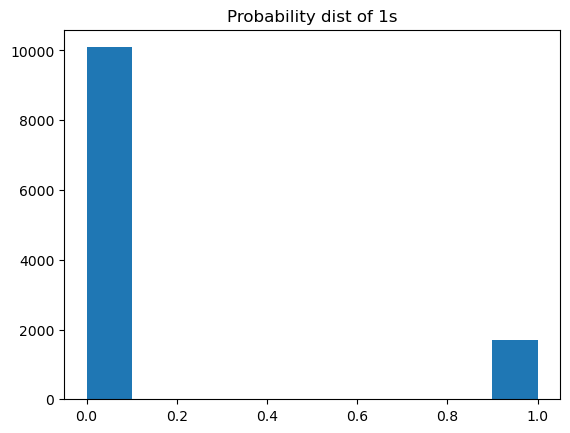

In [340]:
plt.hist(y_log_reg_predict_proba)
plt.title("Probability dist of 1s")

#### Calculate all possible thresholds and get the ones that result in the best f1 score measure for each model

In [344]:
# define possible thresholds
thresholds = arange(0, 1, 0.001)

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')


probas_list = [y_log_reg_predict_proba, y_forest_predict_proba, 
               y_xgb_predict_proba]

def threshold_eval(probas_list):
    
    scores_list = []
    for prob in probas_list:
        
        scores_cust = [f1_score(y_test, to_labels(prob, t)) for t in thresholds]
        scores_list.append(scores_cust)
    
    return tuple(scores_list)

In [345]:
scores_log_reg, scores_forest, scores_xgb, = threshold_eval(probas_list)

In [346]:
list_of_scores = [scores_log_reg, scores_forest, scores_xgb]

In [350]:
def get_best_thresholds(list_of_scores):
    
    n = 0
    print_list = ["LogReg:", "RF:", "XGB:"]
    for s in list_of_scores:
        
        
        ix = argmax(s)
        print(print_list[n])
        print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], s[ix]))
        print()
        n += 1

In [351]:
# Check the f1 scores first:
print(f" F1 Score LogReg: {f1_score(y_test, y_log_reg_predict)}")
print(f" F1 Score RF: {f1_score(y_test, y_forest_predict)}")
print(f" F1 Score XGB: {f1_score(y_test, y_xgb_predict)}")

 F1 Score LogReg: 0.2564499484004128
 F1 Score RF: 0.31117912840693784
 F1 Score XGB: 0.3144123846209754


In [352]:
get_best_thresholds(list_of_scores)

LogReg:
Threshold=0.000, F-Score=0.30990

RF:
Threshold=0.501, F-Score=0.31118

XGB:
Threshold=0.992, F-Score=0.73917



The above results show that if we change the thresholds from 0.5 the F-Scores could be improved by some margin

#### Log Reg with new threshold

In [354]:
log_reg_threshold = 0.000
log_reg_new_preds = np.where(log_reg_clf.predict_proba(X_test_fs)[:,1] > log_reg_threshold, 1, 0)

In [355]:
n_correct_log_reg_new = sum(log_reg_new_preds == y_test)
log_reg_predict_proba_new = log_reg_clf.predict_proba(X_test_fs)

print(f"Old_Prediction_LogReg: {(n_correct_log_reg / len(y_log_reg_predict))}")
print(f"New_Prediction_LogReg: {(n_correct_log_reg_new / len(log_reg_new_preds))}")

Old_Prediction_LogReg: 0.7558041009998305
New_Prediction_LogReg: 0.7552109811896289


In [356]:
precisions_log_reg_test_new, recalls_log_reg_test_new, thresholds_log_reg_test_new = precision_recall_curve(y_test, log_reg_new_preds)

In [357]:
print(f" Old Confusion matrix:   \n  {confusion_matrix(y_test, y_log_reg_predict)}")
print()
print(f" New Confusion matrix:   \n  {confusion_matrix(y_test, log_reg_new_preds)}")

 Old Confusion matrix:   
  [[8423 1215]
 [1667  497]]

 New Confusion matrix:   
  [[8414 1224]
 [1665  499]]


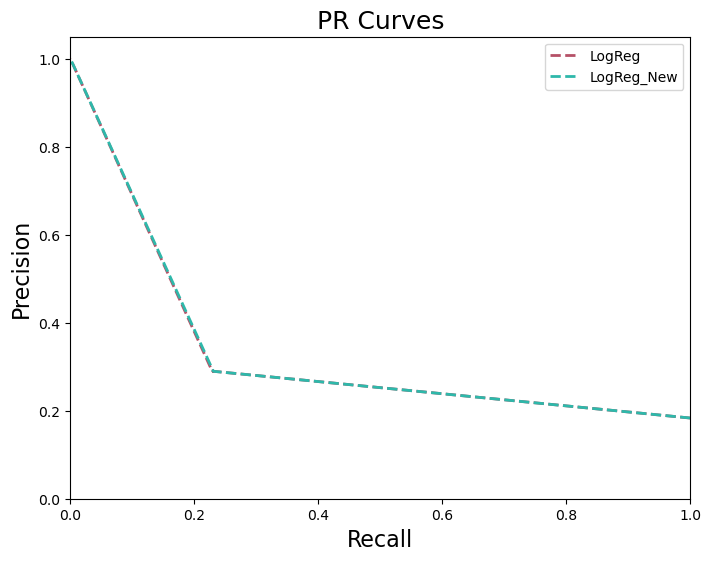

AUC LogReg: 0.32998804521930425
AUC LogReg_New: 0.3306402120042543


In [384]:
plt.figure(figsize=(8, 6))

plot_precision_vs_recall(precisions_log_reg_test, recalls_log_reg_test, color="#b55167", label="LogReg")
plot_precision_vs_recall(precisions_log_reg_test_new, recalls_log_reg_test_new, color="#2eb8aa", label="LogReg_New")
plt.legend()
plt.show()

print(f"AUC LogReg: {auc(recalls_log_reg_test, precisions_log_reg_test)}")
print(f"AUC LogReg_New: {auc(recalls_log_reg_test_new, precisions_log_reg_test_new)}")

#### Random Forest with new threshold

In [362]:
rf_threshold = 0.501
rf_new_preds = np.where(forest_clf.predict_proba(X_test_fs)[:,1] > rf_threshold, 1, 0)

In [364]:
n_correct_rf_new = sum(rf_new_preds == y_test)
rf_predict_proba_new = forest_clf.predict_proba(X_test_fs)

print(f"Old_Prediction_RF: {(n_correct_forest / len(y_forest_predict))}")
print(f"New_Prediction_RF: {(n_correct_rf_new / len(rf_new_preds))}")

Old_Prediction_RF: 0.19911879342484326
New_Prediction_RF: 0.19911879342484326


In [365]:
precisions_rf_test_new, recalls_rf_test_new, thresholds_rf_test_new = precision_recall_curve(y_test, rf_new_preds)

In [366]:
print(f" Old Confusion matrix:   \n  {confusion_matrix(y_test, y_forest_predict)}")
print()
print(f" New Confusion matrix:   \n  {confusion_matrix(y_test, rf_new_preds)}")

 Old Confusion matrix:   
  [[ 215 9423]
 [  29 2135]]

 New Confusion matrix:   
  [[ 215 9423]
 [  29 2135]]


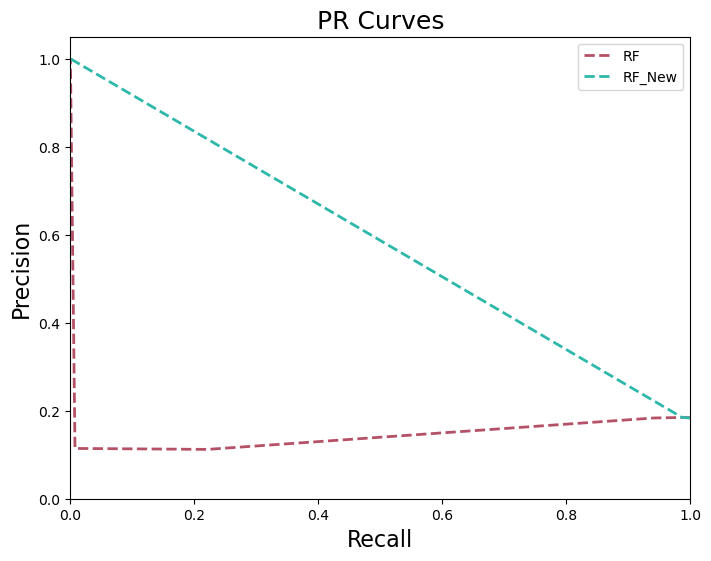

AUC Random_Forest: 0.1455763547682565
AUC Random_Forest_New: 0.5868883207353781


In [385]:
plt.figure(figsize=(8, 6))

plot_precision_vs_recall(precisions_forest_test, recalls_forest_test, color="#b55167", label="RF")
plot_precision_vs_recall(precisions_rf_test_new, recalls_rf_test_new, color="#2eb8aa", label="RF_New")
plt.legend()
plt.show()

print(f"AUC Random_Forest: {auc(recalls_forest_test, precisions_forest_test)}")
print(f"AUC Random_Forest_New: {auc(recalls_rf_test_new, precisions_rf_test_new)}")

#### Gradient Boost with new threshold

In [368]:
xgb_threshold = 0.992
xgb_new_preds = np.where(xgb_clf.predict_proba(X_test_fs)[:,1] > xgb_threshold, 1, 0)

In [396]:
n_correct_xgb_new = sum(xgb_new_preds == y_test)
xgb_predict_proba_new = xgb_clf.predict_proba(X_test_fs)

print(f"Old_Prediction_XGB: {(n_correct_xgb / len(y_xgb_predict))}")
print(f"New_Prediction_XGB: {(n_correct_xgb_new / len(xgb_new_preds))}")

Old_Prediction_XGB: 0.20072869005253346
New_Prediction_XGB: 0.9122182680901542


In [393]:
xgb_predict_proba_new

array([[0.18489599, 0.815104  ],
       [0.09187406, 0.90812594],
       [0.08090687, 0.91909313],
       ...,
       [0.08090687, 0.91909313],
       [0.29340893, 0.70659107],
       [0.29340893, 0.70659107]], dtype=float32)

In [377]:
precisions_xgb_test_new, recalls_xgb_test_new, thresholds_xgb_test_new = precision_recall_curve(y_test, xgb_new_preds)

In [378]:
print(f" Old Confusion matrix:   \n  {confusion_matrix(y_test, y_xgb_predict)}")
print()
print(f" New Confusion matrix:   \n  {confusion_matrix(y_test, xgb_new_preds)}")

 Old Confusion matrix:   
  [[ 206 9432]
 [   1 2163]]

 New Confusion matrix:   
  [[9298  340]
 [ 696 1468]]


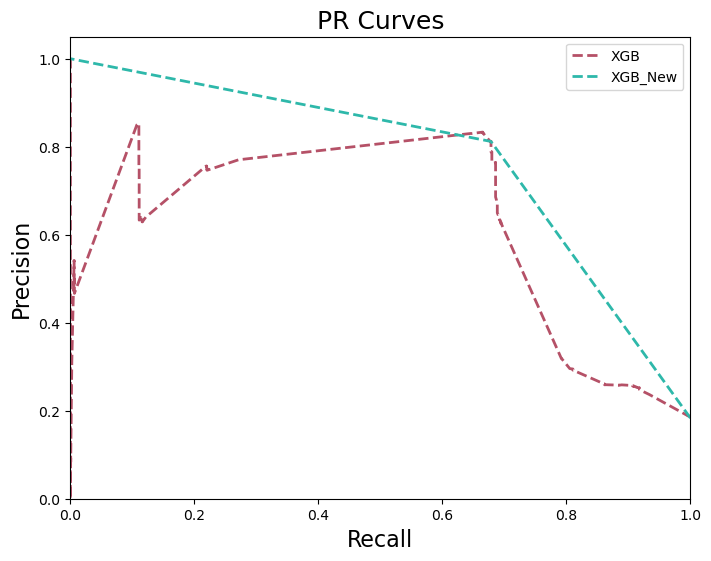

AUC GR_Boost: 0.6221778641965249
AUC GR_Boost_New: 0.7746466703469863


In [387]:
plt.figure(figsize=(8, 6))

plot_precision_vs_recall(precisions_xgb_test, recalls_xgb_test, color="#b55167", label="XGB")
plot_precision_vs_recall(precisions_xgb_test_new, recalls_xgb_test_new, color="#2eb8aa", label="XGB_New")
plt.legend()
plt.show()

print(f"AUC GR_Boost: {auc(recalls_xgb_test, precisions_xgb_test)}")
print(f"AUC GR_Boost_New: {auc(recalls_xgb_test_new, precisions_xgb_test_new)}")

### Final prediction scores and performance measures

In [389]:
print(f"New_Prediction_LogReg: {(n_correct_log_reg_new / len(log_reg_new_preds))}")
print(f"New_Prediction_RF: {(n_correct_rf_new / len(rf_new_preds))}")
print(f"New_Prediction_GRB: {(n_correct_xgb_new / len(xgb_new_preds))}")

New_Prediction_LogReg: 0.7552109811896289
New_Prediction_RF: 0.19911879342484326
New_Prediction_GRB: 0.9122182680901542


In [390]:
print(xgb_clf.feature_importances_)

[0.00467779 0.00341952 0.         0.         0.03211306 0.00308776
 0.00365714 0.00203908 0.         0.         0.00994699 0.00251608
 0.         0.         0.         0.         0.01076017 0.
 0.         0.         0.         0.         0.00334396 0.
 0.         0.00352161 0.00346775 0.00277464 0.00626373 0.00489875
 0.00457136 0.00280525 0.00353329 0.09281036 0.00335375 0.00429038
 0.00288083 0.00378068 0.01221531 0.00370771 0.00338713 0.00378403
 0.00320645 0.00414683 0.0043244  0.0067124  0.0032365  0.0030672
 0.00381415 0.5969508  0.00318279 0.00349716 0.00363975 0.00390203
 0.0083463  0.00319084 0.0731588  0.03312607 0.00488928]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

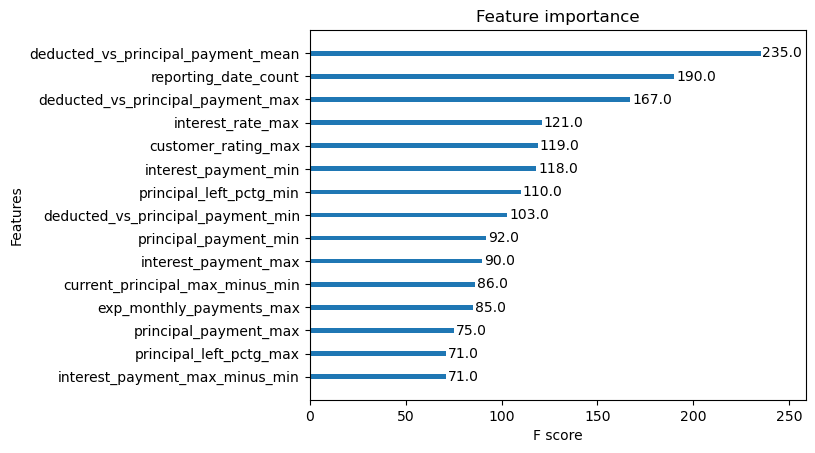

In [410]:
from xgboost import plot_importance
plot_importance(xgb_clf, height=0.2, grid=False, max_num_features=15)

In [394]:
log_reg_predict_proba_new = log_reg_predict_proba_new[:, 1]
rf_predict_proba_new = rf_predict_proba_new[:, 1]
xgb_predict_proba_new = xgb_predict_proba_new[:, 1]



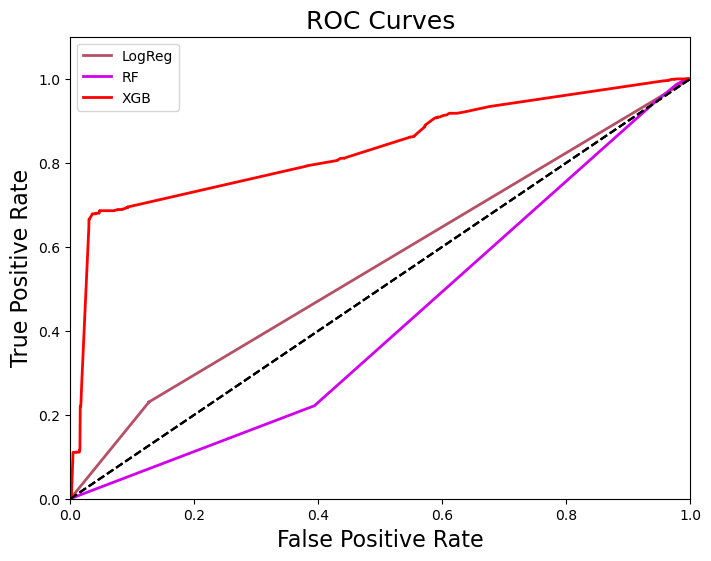

In [395]:
# fpr_sgd_test, tpr_sgd_test, thresholds_sgd_test = roc_curve(y_test, y_sgd_predict)
fpr_log_reg_test, tpr_log_reg_test, thresholds_log_reg_test = roc_curve(y_test, log_reg_predict_proba_new)
fpr_forest_test, tpr_forest_test, thresholds_forest_test = roc_curve(y_test, rf_predict_proba_new)
# fpr_grb_test, tpr_grb_test, thresholds_grb_test = roc_curve(y_test, y_grb_predict_proba)
fpr_xgb_test, tpr_xgb_test, thresholds_xgb_test = roc_curve(y_test, xgb_predict_proba_new)
# fpr_lgbm_test, tpr_lgbm_test, thresholds_lgbm_test = roc_curve(y_test, y_lgbm_predict_proba)





plt.figure(figsize=(8, 6))
# plot_roc_curve(fpr_sgd_test, tpr_sgd_test, label="SGD")
plot_roc_curve(fpr_log_reg_test, tpr_log_reg_test, color="#b55167", label="LogReg")
plot_roc_curve(fpr_forest_test, tpr_forest_test, color="#d000eb", label="RF")
# plot_roc_curve(fpr_grb_test, tpr_grb_test, color="#ebc700", label="GRB")
plot_roc_curve(fpr_xgb_test, tpr_xgb_test, color="r", label="XGB")
# plot_roc_curve(fpr_lgbm_test, tpr_lgbm_test, color="c", label="LGBM")
plt.legend()
plt.show()

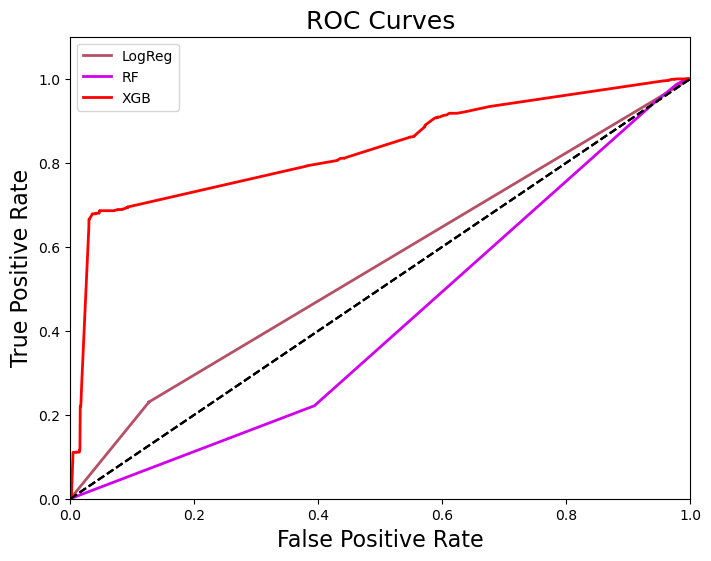

In [397]:
# fpr_sgd_test, tpr_sgd_test, thresholds_sgd_test = roc_curve(y_test, y_sgd_predict)
fpr_log_reg_test, tpr_log_reg_test, thresholds_log_reg_test = roc_curve(y_test, y_log_reg_predict_proba)
fpr_forest_test, tpr_forest_test, thresholds_forest_test = roc_curve(y_test, y_forest_predict_proba)
# fpr_grb_test, tpr_grb_test, thresholds_grb_test = roc_curve(y_test, y_grb_predict_proba)
fpr_xgb_test, tpr_xgb_test, thresholds_xgb_test = roc_curve(y_test, y_xgb_predict_proba)
# fpr_lgbm_test, tpr_lgbm_test, thresholds_lgbm_test = roc_curve(y_test, y_lgbm_predict_proba)





plt.figure(figsize=(8, 6))
# plot_roc_curve(fpr_sgd_test, tpr_sgd_test, label="SGD")
plot_roc_curve(fpr_log_reg_test, tpr_log_reg_test, color="#b55167", label="LogReg")
plot_roc_curve(fpr_forest_test, tpr_forest_test, color="#d000eb", label="RF")
# plot_roc_curve(fpr_grb_test, tpr_grb_test, color="#ebc700", label="GRB")
plot_roc_curve(fpr_xgb_test, tpr_xgb_test, color="r", label="XGB")
# plot_roc_curve(fpr_lgbm_test, tpr_lgbm_test, color="c", label="LGBM")
plt.legend()
plt.show()